In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

# Visualize Results

In [11]:
import jax
import jax.numpy as jnp
from jax.random import split

from create_sim import create_sim, rollout_and_embed_simulation, FlattenSimulationParameters
from models.models_gol import GameOfLifeInit
from clip_jax import MyFlaxCLIP

In [5]:
clip_model = MyFlaxCLIP()

/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-09-17 22:49:11.322113: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [79]:
sim = GameOfLifeInit()
sim = FlattenSimulationParameters(sim)

ParameterReshaper: 4096 parameters detected for optimization.


In [91]:
rollout_fn = partial(rollout_and_embed_simulation, sim=sim, clip_model=clip_model, rollout_steps=2048, n_rollout_imgs=32)
rollout_fn = jax.jit(rollout_fn)

In [98]:
def mutate_params(rng, params):
    mask = jax.random.uniform(rng, params.shape)
    mask = (mask+0.001).astype(int)
    params = (params+mask)%2
    return params

def get_fitness(rng, params):
    data = rollout_fn(rng, params)
    z = data['z']
    scores_novelty = (z @ z.T) # T T
    scores_novelty = jnp.tril(scores_novelty, k=-1)
    loss_novelty = scores_novelty.max(axis=-1) # T
    return loss_novelty[1:].mean()

get_fitness = jax.jit(jax.vmap(get_fitness))

In [99]:
from IPython.display import clear_output

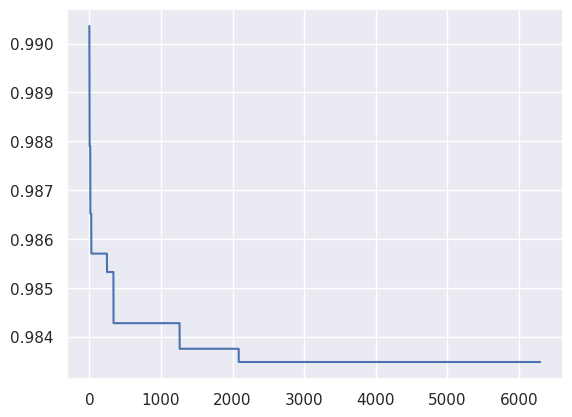

KeyboardInterrupt: 

In [100]:
rng = jax.random.PRNGKey(0)
params = sim.default_params(rng)
# params = jnp.zeros_like(params)

loss = []
for i in tqdm(range(10000)):
    rng, _rng = split(rng)
    pop = jax.vmap(mutate_params, in_axes=(0, None))(split(_rng, 7), params)
    pop = jnp.concatenate([params[None], pop], axis=0)

    rng, _rng = split(rng)
    fitness = get_fitness(split(_rng, len(pop)), pop)
    params = pop[jnp.argmin(fitness)]
    loss.append(fitness.min())


    if i%100 == 0:
        clear_output(wait=True)
        plt.plot(loss)
        plt.show()




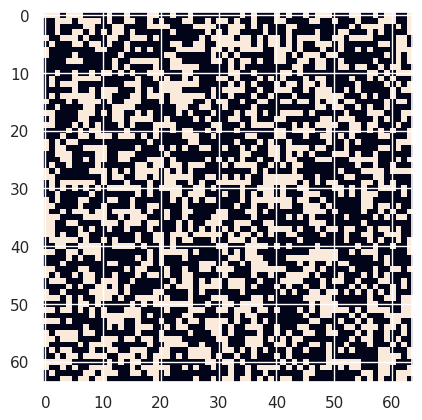

In [101]:
plt.imshow(params.reshape(64, 64))
plt.show()

In [10]:
jax.vmap(get_fitness, in_axes=(None, 0))(rng, jax.vmap(sim.default_params)(split(rng, 4)))

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName
2024-09-17 22:49:22.088189: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[1024,768,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,3,224,224]{3,2,1,0}, f32[768,3,32,32]{3,2,1,0}), window={size=32x32 stride=32x32}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-09-17 22:49:22.538804: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.450726666s
Trying algorithm eng0{} for conv (f32[1024,768,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,3,224,224]{3,2,1,0}, f32[768,3,32,32]{3,2,1,0}), window={size=32x32 stride=32x32}, dim_labels=bf01_oi01->b

Array([0.99469274, 0.99357694, 0.99327254, 0.99461997], dtype=float32)

In [60]:
z = rollout_fn(rng, params)['z']

In [61]:
z.shape

(256, 512)

In [63]:
(z@z.T).shape

(256, 256)